<a href="https://colab.research.google.com/github/dparnas/cc_bai/blob/main/Bandit_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy

Cost-Aware Multi-Arm Environment

In [2]:
class CostAwareMultiArmBandit:
    def __init__(self, L, cost_variance=None, random_seed=0):
        """
        Initialize the multi-arm bandit environment with rewards and costs

        Parameters:
        L (int): Number of arms.
        """
        np.random.seed(random_seed)
        self.L = L
        self.arm_reward_probabilities = np.random.rand(L)  # Bernoulli success probabilities for each arm
        self.arm_cost_expectations = np.random.uniform(low=0.1, high=0.9, size=L)  # Normal expectations for each arm
        self.costs = np.zeros(L)  # To keep track of the cost of each arm
        self.rewards = np.zeros(L)
        self.times_pulled = np.zeros(L)
        self.cost_variance = cost_variance if cost_variance is not None else 0.5
        self.unnormalized_cumulative_regret = 0

    def set_arm_reward_probabilities(self, arm_reward_probabilities):
        self.arm_reward_probabilities = np.array(arm_reward_probabilities)

    def set_arm_cost_expectations(self, arm_cost_expectations):
        self.arm_cost_expectations = np.array(arm_cost_expectations)

    def pull_arm(self, arm):
        """
        Simulate pulling arm and record reward, costs, times pulled

        Parameters:
        arm (int): Index of the arm to pull.

        Returns:
        reward (int): 1 if successful, 0 otherwise.
        cost (float): Random cost between 0 and 1.
        """
        if arm < 0 or arm >= self.L:
            raise ValueError("Invalid arm index.")

        reward = np.random.binomial(1, self.arm_reward_probabilities[arm])
        cost = np.clip(np.random.normal(self.arm_cost_expectations[arm], self.cost_variance), a_min=0, a_max=None)
        self.rewards[arm] += reward
        self.costs[arm] += cost
        self.times_pulled[arm] += 1
        return reward, cost

    def get_ideal_arm_order(self):
      reward_cost_ratio = self.arm_reward_probabilities / self.arm_cost_expectations
      ordered_arms = np.argsort(-self.arm_reward_probabilities / self.arm_cost_expectations)
      ideal_ordered_arms = ordered_arms[:np.sum(reward_cost_ratio >= 1)]
      return ideal_ordered_arms

    # def ideal_arms(self):
    #   reward_cost_ratio = self.arm_reward_probabilities / self.arm_cost_expectations
    #   # print(reward_cost_ratio)
    #   return (reward_cost_ratio >= 1)
    def get_step_reward(self, arm_list):
      step_reward = 0
      for i, arm in enumerate(arm_list):
        step_reward += (self.arm_reward_probabilities[arm] - self.arm_cost_expectations[arm]) * np.prod(1 - self.arm_reward_probabilities[arm_list[:i]])
      return step_reward

    def get_ideal_reward(self):
      ideal_arms = self.get_ideal_arm_order()
      return self.get_step_reward(ideal_arms)

    def get_step_regret(self, arm_list):
      return self.get_ideal_reward() - self.get_step_reward(arm_list)

    def update_cumulative_regret(self, arm_list):
      self.unnormalized_cumulative_regret += self.get_step_regret(arm_list)
    def get_cumulative_regret(self, step):
      return self.unnormalized_cumulative_regret / step

In [3]:
class cc_bai_run:
  def __init__(self, L, delta, epsilon, probability_cutoff, num_estimate_probability_simulations, exploration_horizon):
    # Algorithm Parametes
    self.L = L
    self.delta = delta
    self.epsilon = epsilon
    self.probability_cutoff = probability_cutoff

    self.weights = np.zeros(L)
    self.env = CostAwareMultiArmBandit(L)
    # Simulation Parameters
    self.exploration_horizon = exploration_horizon
    self.num_estimate_probability_simulations = num_estimate_probability_simulations
    self.estimated_win_probability = self.simulate_probability_of_beating_cost(reward_probabilities=self.env.arm_reward_probabilities, cost_expectations=self.env.arm_cost_expectations, cost_variance=self.env.cost_variance, number_of_simulations=self.num_estimate_probability_simulations)

    # Record Arm-level Statistics
    self.reward_list = list()
    self.cost_list = list()
    self.times_pulled_list = list()

  @staticmethod
  def find_closest_indices(array, x):
    # Sort the array and get sorted indices
    sorted_indices = np.argsort(array)
    sorted_array = array[sorted_indices]

    # Find the indices of the values below and above x
    below_index = sorted_indices[np.where(sorted_array < x)[0][-1]] if np.any(sorted_array < x) else None
    above_index = sorted_indices[np.where(sorted_array > x)[0][0]] if np.any(sorted_array > x) else None

    return below_index, above_index
  @staticmethod
  def simulate_probability_of_beating_cost(reward_probabilities, cost_expectations, cost_variance, number_of_simulations):
    sum_wins = np.zeros(len(reward_probabilities))
    for i in range(number_of_simulations):
      reward = np.random.binomial(1, reward_probabilities)
      cost = np.clip(np.random.normal(cost_expectations, cost_variance), a_min=0, a_max=1)
      sum_wins += (reward > cost).astype(int)
    return sum_wins/number_of_simulations

  def best_arm_exploration(self):
    discovery_group = np.array(list(range(self.L)))
    accepted_set = set()
    rejected_set = set()
    step = 0
    # EXPLORATION
    while len(discovery_group) > 0:
      step_arm_order = discovery_group[np.argsort(self.env.times_pulled[discovery_group])]
      for arm in step_arm_order:
        arm_reward, arm_cost = self.env.pull_arm(arm)
        # reward_beats_cost = (arm_reward > arm_cost).astype(int)
        reward_beats_cost = ((self.env.rewards[arm]/self.env.times_pulled[arm]) > (self.env.costs[arm]/self.env.times_pulled[arm])).astype(int)
        self.weights[arm] = (self.weights[arm] * (self.env.times_pulled[arm]-1) + reward_beats_cost)/self.env.times_pulled[arm]
        if arm_reward == 1:
          break
      step += 1

      confidence_radius = 4 * np.sqrt(np.log(np.log2(2*self.env.times_pulled[arm])/np.sqrt(self.delta/(12*self.L)))/self.env.times_pulled[arm])
      upper_confidence_bound = self.weights + confidence_radius
      lower_confidence_bound = self.weights - confidence_radius
      below_probability_cutoff_index, above_probability_cutoff_index = self.find_closest_indices(self.weights, self.probability_cutoff)

      if above_probability_cutoff_index is not None:
        accepted_set.update((lower_confidence_bound > upper_confidence_bound[below_probability_cutoff_index] - self.epsilon).nonzero()[0])
      if below_probability_cutoff_index is not None:
        rejected_set.update((upper_confidence_bound < lower_confidence_bound[above_probability_cutoff_index] - self.epsilon).nonzero()[0])
      discovery_group = np.fromiter(set(discovery_group).difference(accepted_set, rejected_set), int)

      self.reward_list.extend(self.env.rewards)
      self.cost_list.extend(self.env.costs)
      self.times_pulled_list.extend(self.env.times_pulled)
      # env.update_cumulative_regret(step_arm_order)
      # cumulative_regret_list.append(env.get_cumulative_regret(step))
    self.exploration_steps = step
    accepted_arms = np.fromiter(accepted_set, int)
    accepted_arms_estimated_reward_expectation = self.env.rewards[accepted_arms]/self.env.times_pulled[accepted_arms]
    accepted_arms_estimated_cost_expectation = self.env.costs[accepted_arms]/self.env.times_pulled[accepted_arms]
    self.cc_bai_policy = list(accepted_arms[np.argsort(-accepted_arms_estimated_reward_expectation/accepted_arms_estimated_cost_expectation)])

  def exploitation(self):
    # Run specific paramaters
    step = 0 # reset for exploitation phase
    cumulative_reward = 0
    cumulative_cost = 0
    self.exploitation_reward_list = self.reward_list
    self.exploitation_cost_list = self.cost_list
    self.exploitation_times_pulled_list = self.times_pulled_list
    # Post-Exploration Step Level Statistics
    self.cumulative_regret_list = list()
    self.cumulative_reward_list = list()
    self.cumulative_cost_list = list()
    self.cumulative_difference_list = list()
    self.cumulative_reward = 0
    self.cumulative_cost = 0

    while True:
      for arm in self.cc_bai_policy:
        arm_reward, arm_cost = self.env.pull_arm(arm)
        # reward_beats_cost = (arm_reward > arm_cost).astype(int)
        cumulative_reward += arm_reward
        cumulative_cost += arm_cost
        # print(step, arm, arm_reward, arm_cost)
        if arm_reward == 1:
          break
      self.cumulative_reward_list.append(cumulative_reward)
      self.cumulative_cost_list.append(cumulative_cost)
      self.cumulative_difference_list.append(cumulative_reward - cumulative_cost)
      self.exploitation_reward_list.extend(self.env.rewards)
      self.exploitation_cost_list.extend(self.env.costs)
      self.exploitation_times_pulled_list.extend(self.env.times_pulled)
      self.env.update_cumulative_regret(self.cc_bai_policy)
      self.cumulative_regret_list.append(self.env.get_cumulative_regret(step+1))
      step += 1
      if step > self.exploration_horizon - 1:
        break
    self.arm_statistics = pd.DataFrame({"reward": self.exploitation_reward_list, "cost": self.exploitation_cost_list, "times_pulled": self.exploitation_times_pulled_list, "arm": list(range(self.L)) * int(len(self.exploitation_reward_list)/self.L), "step": sorted(list(range(self.exploration_steps + self.exploration_horizon)) * self.L)})
    self.step_statistics = pd.DataFrame({"cumulative_regret": self.cumulative_regret_list, "cumulative_reward": self.cumulative_reward_list, "cumulative_cost": self.cumulative_cost_list, "cumulative_difference": self.cumulative_difference_list, "step": list(range(self.exploration_horizon))})

  def visualize_results(self, upper_regret_ylim):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    sns.lineplot(data=self.step_statistics, x="step", y="cumulative_reward", ax=axes[0][0], label="Reward")
    sns.lineplot(data=self.step_statistics, x="step", y="cumulative_cost", ax=axes[0][0], label="Cost")
    axes[0][0].set_ylim(0, self.exploration_horizon)
    axes[0][0].set_ylabel("Reward vs. Cost")
    axes[0][0].set_title("Cumulative Reward vs. Cost")
    sns.lineplot(data=self.step_statistics, x="step", y="cumulative_difference", ax=axes[0][1])
    axes[0][1].set_title("Cumulative Difference")
    sns.lineplot(data=self.step_statistics, x="step", y="cumulative_regret", ax=axes[0][2])
    axes[0][2].set_title("Cumulative Regret")
    axes[0][2].set_ylim(0, upper_regret_ylim)
    # Arm Statistics
    sns.lineplot(data=self.arm_statistics, x="step", y="reward", hue="arm", ax=axes[1][0])
    axes[1][0].axvline(x=self.exploration_steps, color='r', linestyle='--')
    axes[1][0].set_title("Rewards")
    sns.lineplot(data=self.arm_statistics, x="step", y="cost", hue="arm", ax=axes[1][1])
    axes[1][1].axvline(x=self.exploration_steps, color='r', linestyle='--')
    axes[1][1].set_title("Costs")
    sns.lineplot(data=self.arm_statistics, x="step", y="times_pulled", hue="arm", ax=axes[1][2])
    axes[1][2].axvline(x=self.exploration_steps, color='r', linestyle='--')
    axes[1][2].set_title("Times Arm Pulled")
    plt.legend()
    plt.show()

Exploration took 4152 steps
CC_BAI Policy: [5, 6, 4, 8, 1, 7, 2]
Ideal Policy: [5 6 4 1 8 7 2]
CC_BAI Policy Regret: 0.0014502770144710908


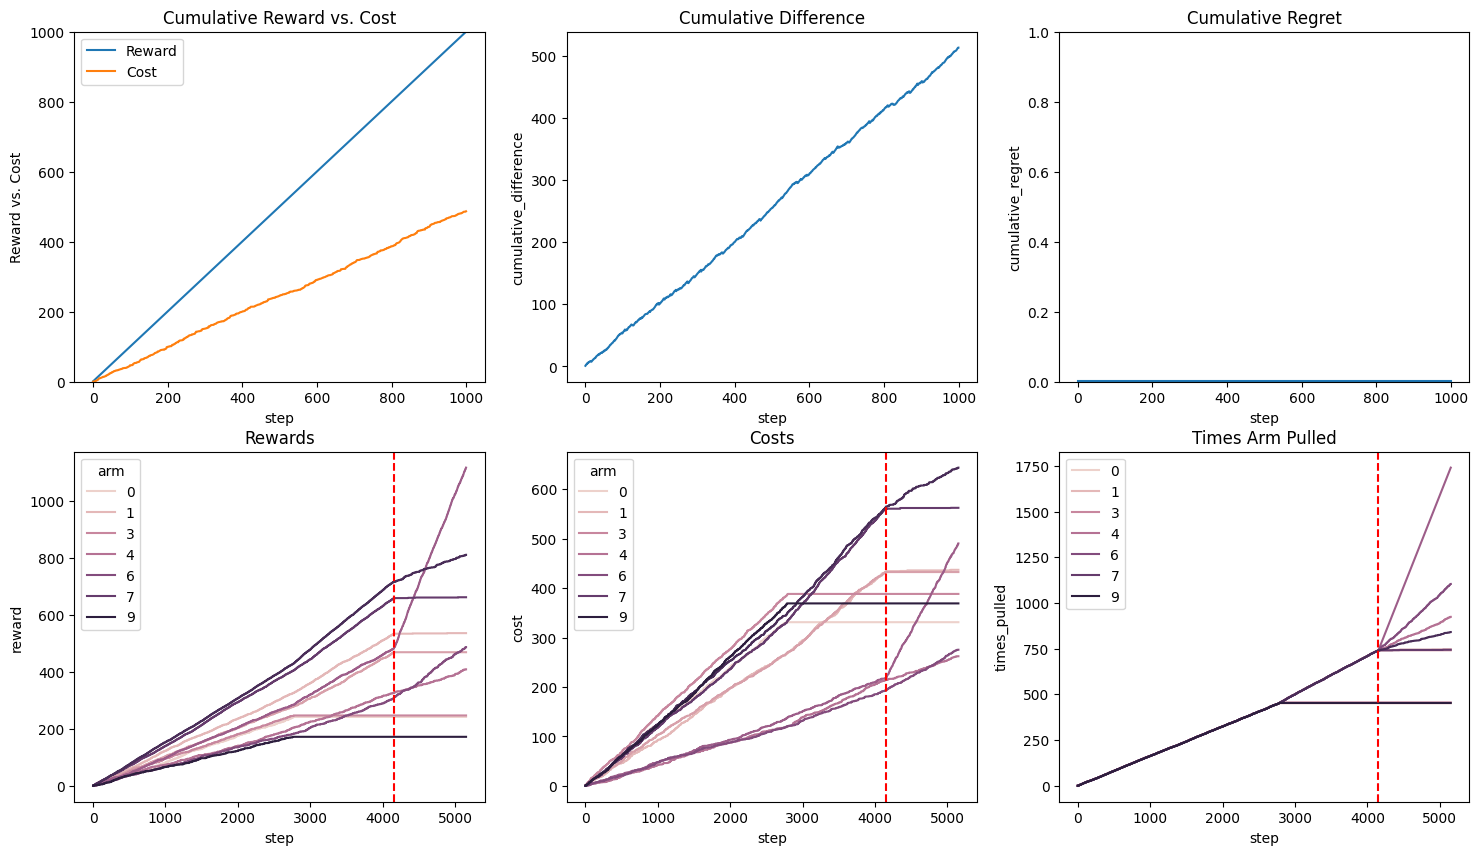

In [4]:
# Simulation Parameters
exploration_horizon = 1000
num_estimate_probability_simulations = 10
# Algorithm Parametes
L_bai = 10
delta_bai = 0.2
epsilon_bai = 0.1
risk_averse_cutoff = 0.95

bai_risk_averse = cc_bai_run(L_bai, delta_bai, epsilon_bai, risk_averse_cutoff, num_estimate_probability_simulations, exploration_horizon)
bai_risk_averse.best_arm_exploration()
print(f"Exploration took {bai_risk_averse.exploration_steps} steps")
print(f"CC_BAI Policy: {bai_risk_averse.cc_bai_policy}")
print(f"Ideal Policy: {bai_risk_averse.env.get_ideal_arm_order()}")
print(f"CC_BAI Policy Regret: {bai_risk_averse.env.get_step_regret(bai_risk_averse.cc_bai_policy)}")
bai_risk_averse.exploitation()
bai_risk_averse.visualize_results(1)

Exploration took 2287 steps
CC_BAI Policy: [5, 4, 6, 7, 1, 8, 2]
Ideal Policy: [5 6 4 1 8 7 2]
CC_BAI Policy Regret: 0.019286774914684002


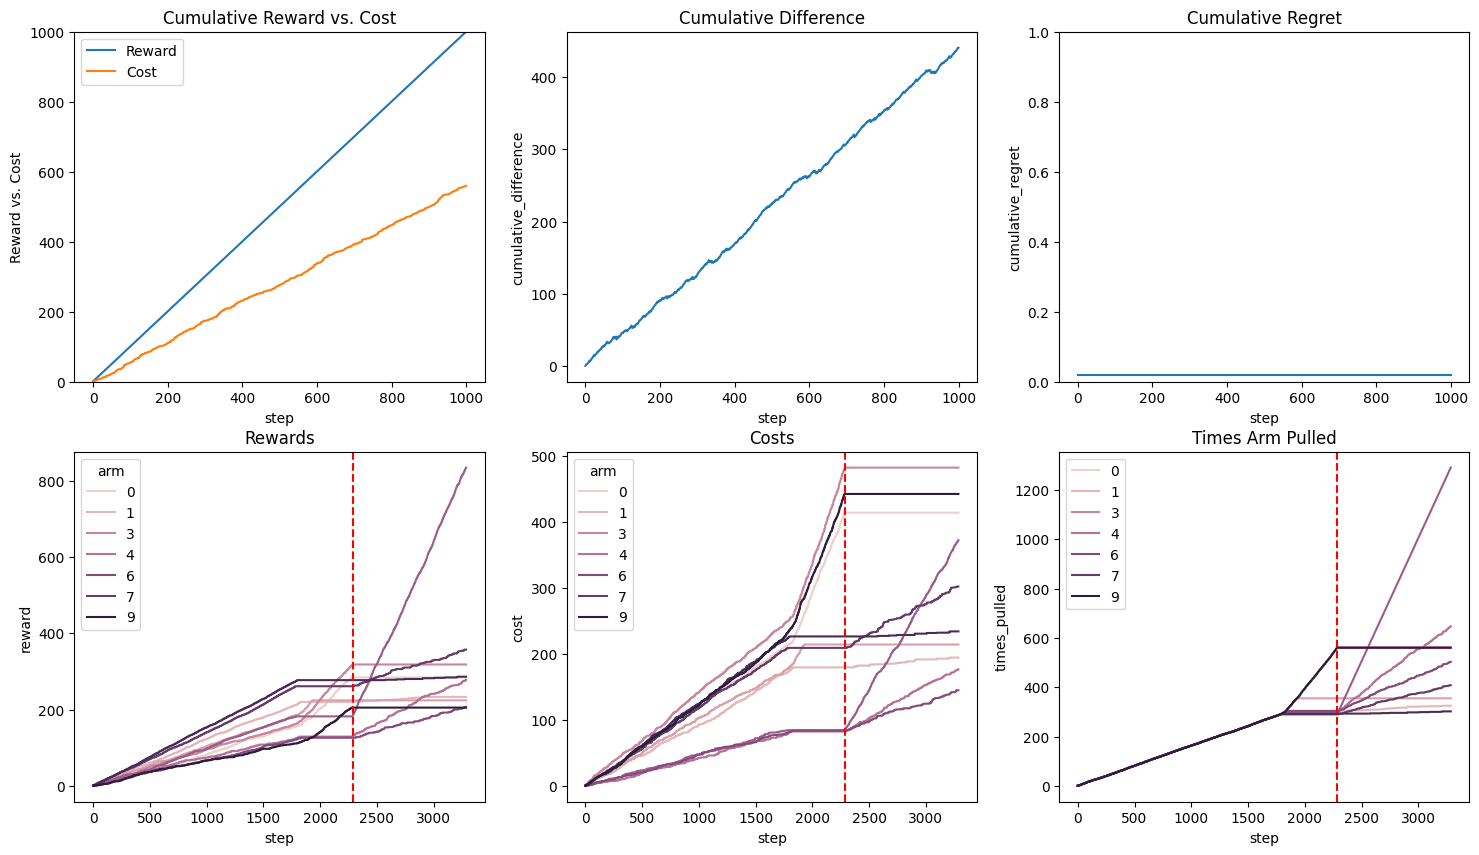

In [5]:
# Simulation Parameters
exploration_horizon = 1000
num_estimate_probability_simulations = 10
# Algorithm Parametes
L_bai = 10
delta_bai = 0.2
epsilon_bai = 0.1
risky_cutoff = 0.75

bai_risky = cc_bai_run(L_bai, delta_bai, epsilon_bai, risky_cutoff, num_estimate_probability_simulations, exploration_horizon)
bai_risky.best_arm_exploration()
print(f"Exploration took {bai_risky.exploration_steps} steps")
print(f"CC_BAI Policy: {bai_risky.cc_bai_policy}")
print(f"Ideal Policy: {bai_risky.env.get_ideal_arm_order()}")
print(f"CC_BAI Policy Regret: {bai_risky.env.get_step_regret(bai_risky.cc_bai_policy)}")
bai_risky.exploitation()
bai_risky.visualize_results(1)

In [6]:
# Simulation Parameters
budget_ccb = bai_risk_averse.exploration_steps
horizon_beyond_budget_ccb = exploration_horizon
horizon_ccb = horizon_beyond_budget_ccb + budget_ccb
# Algorithm Parameters
epsilon_ccb = 0.2
alpha_ccb = 1.5
L_ccb = 10
env_ccb = CostAwareMultiArmBandit(L_ccb)
step_ccb = 0
# Record Arm-level Statistics
reward_list_ccb = list()
cost_list_ccb = list()
times_pulled_list_ccb = list()

# Post-Exploration Step Level Statistics
cumulative_reward_list_ccb = list()
cumulative_cost_list_ccb = list()
cumulative_difference_list_ccb = list()
cumulative_regret_list_ccb = list()
cumulative_reward_ccb = 0
cumulative_cost_ccb = 0

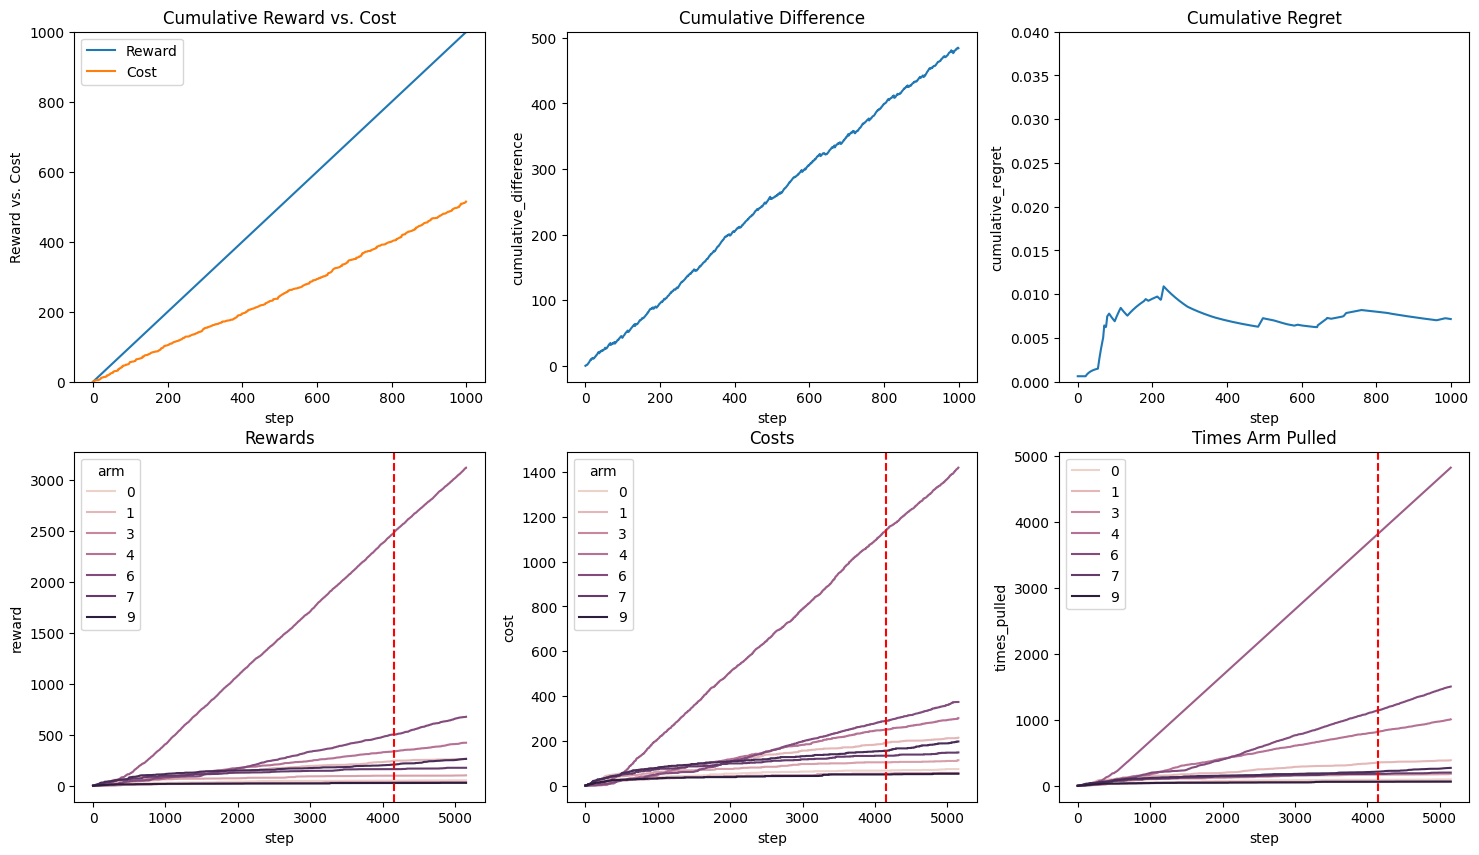

In [7]:
# initialize arms
for arm in range(env_ccb.L):
  env_ccb.pull_arm(arm)
while True:
  ucb_bounds = np.sqrt(alpha_ccb * np.log(step_ccb + 1)/env_ccb.times_pulled)
  upper_arm_bounds = env_ccb.rewards/env_ccb.times_pulled + ucb_bounds
  lower_arm_bounds = np.clip(env_ccb.costs/env_ccb.times_pulled - ucb_bounds, a_min=epsilon_ccb, a_max=None)
  ucb_reward_cost_ratio = upper_arm_bounds / lower_arm_bounds
  ordered_arms = np.argsort(-ucb_reward_cost_ratio)
  step_ordered_arms = ordered_arms[:np.sum(ucb_reward_cost_ratio >= 1)]
  for arm in step_ordered_arms:
    arm_reward, arm_cost = env_ccb.pull_arm(arm)
    if step_ccb > budget_ccb:
      cumulative_reward_ccb += arm_reward
      cumulative_cost_ccb += arm_cost
    if arm_reward == 1:
      break
  step_ccb += 1
  reward_list_ccb.extend(env_ccb.rewards)
  cost_list_ccb.extend(env_ccb.costs)
  times_pulled_list_ccb.extend(env_ccb.times_pulled)

  if step_ccb > budget_ccb:
    cumulative_reward_list_ccb.append(cumulative_reward_ccb)
    cumulative_cost_list_ccb.append(cumulative_cost_ccb)
    cumulative_difference_list_ccb.append(cumulative_reward_ccb - cumulative_cost_ccb)
    env_ccb.update_cumulative_regret(step_ordered_arms)
    cumulative_regret_list_ccb.append(env_ccb.get_cumulative_regret(step_ccb-budget_ccb))
  if step_ccb >= horizon_ccb:
    break

arm_statistics_ccb = pd.DataFrame({"reward": reward_list_ccb, "cost": cost_list_ccb, "times_pulled": times_pulled_list_ccb, "arm": list(range(L_ccb)) * int(len(reward_list_ccb)/L_ccb), "step": sorted(list(range(horizon_ccb)) * L_ccb)})
step_statistics_ccb = pd.DataFrame({"cumulative_regret": cumulative_regret_list_ccb, "cumulative_reward": cumulative_reward_list_ccb, "cumulative_cost": cumulative_cost_list_ccb, "cumulative_difference": cumulative_difference_list_ccb, "step": list(range(horizon_beyond_budget_ccb))})

arm_statistics_ccb_risk_averse = deepcopy(arm_statistics_ccb)
step_statistics_ccb_risk_averse = deepcopy(step_statistics_ccb)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
# Step Statistics
sns.lineplot(data=step_statistics_ccb, x="step", y="cumulative_reward", ax=axes[0][0], label="Reward")
sns.lineplot(data=step_statistics_ccb, x="step", y="cumulative_cost", ax=axes[0][0], label="Cost")
axes[0][0].set_ylabel("Reward vs. Cost")
axes[0][0].set_title("Cumulative Reward vs. Cost")
axes[0][0].set_ylim(0,exploration_horizon)
sns.lineplot(data=step_statistics_ccb, x="step", y="cumulative_difference", ax=axes[0][1])
axes[0][1].set_title("Cumulative Difference")
sns.lineplot(data=step_statistics_ccb, x="step", y="cumulative_regret", ax=axes[0][2])
axes[0][2].set_title("Cumulative Regret")
axes[0][2].set_ylim(0,0.04)
# Arm Statistics
sns.lineplot(data=arm_statistics_ccb, x="step", y="reward", hue="arm", ax=axes[1][0])
axes[1][0].axvline(x=budget_ccb, color='r', linestyle='--')
axes[1][0].set_title("Rewards")
sns.lineplot(data=arm_statistics_ccb, x="step", y="cost", hue="arm", ax=axes[1][1])
axes[1][1].axvline(x=budget_ccb, color='r', linestyle='--')
axes[1][1].set_title("Costs")
sns.lineplot(data=arm_statistics_ccb, x="step", y="times_pulled", hue="arm", ax=axes[1][2])
axes[1][2].axvline(x=budget_ccb, color='r', linestyle='--')
axes[1][2].set_title("Times Arm Pulled")
plt.legend()
plt.show()

In [8]:
# Simulation Parameters
budget_ccb = bai_risky.exploration_steps
horizon_beyond_budget_ccb = exploration_horizon
horizon_ccb = horizon_beyond_budget_ccb + budget_ccb
# Algorithm Parameters
epsilon_ccb = 0.2
alpha_ccb = 1.5
L_ccb = 10
env_ccb = CostAwareMultiArmBandit(L_ccb)
step_ccb = 0
# Record Arm-level Statistics
reward_list_ccb = list()
cost_list_ccb = list()
times_pulled_list_ccb = list()

# Post-Exploration Step Level Statistics
cumulative_reward_list_ccb = list()
cumulative_cost_list_ccb = list()
cumulative_difference_list_ccb = list()
cumulative_regret_list_ccb = list()
cumulative_reward_ccb = 0
cumulative_cost_ccb = 0

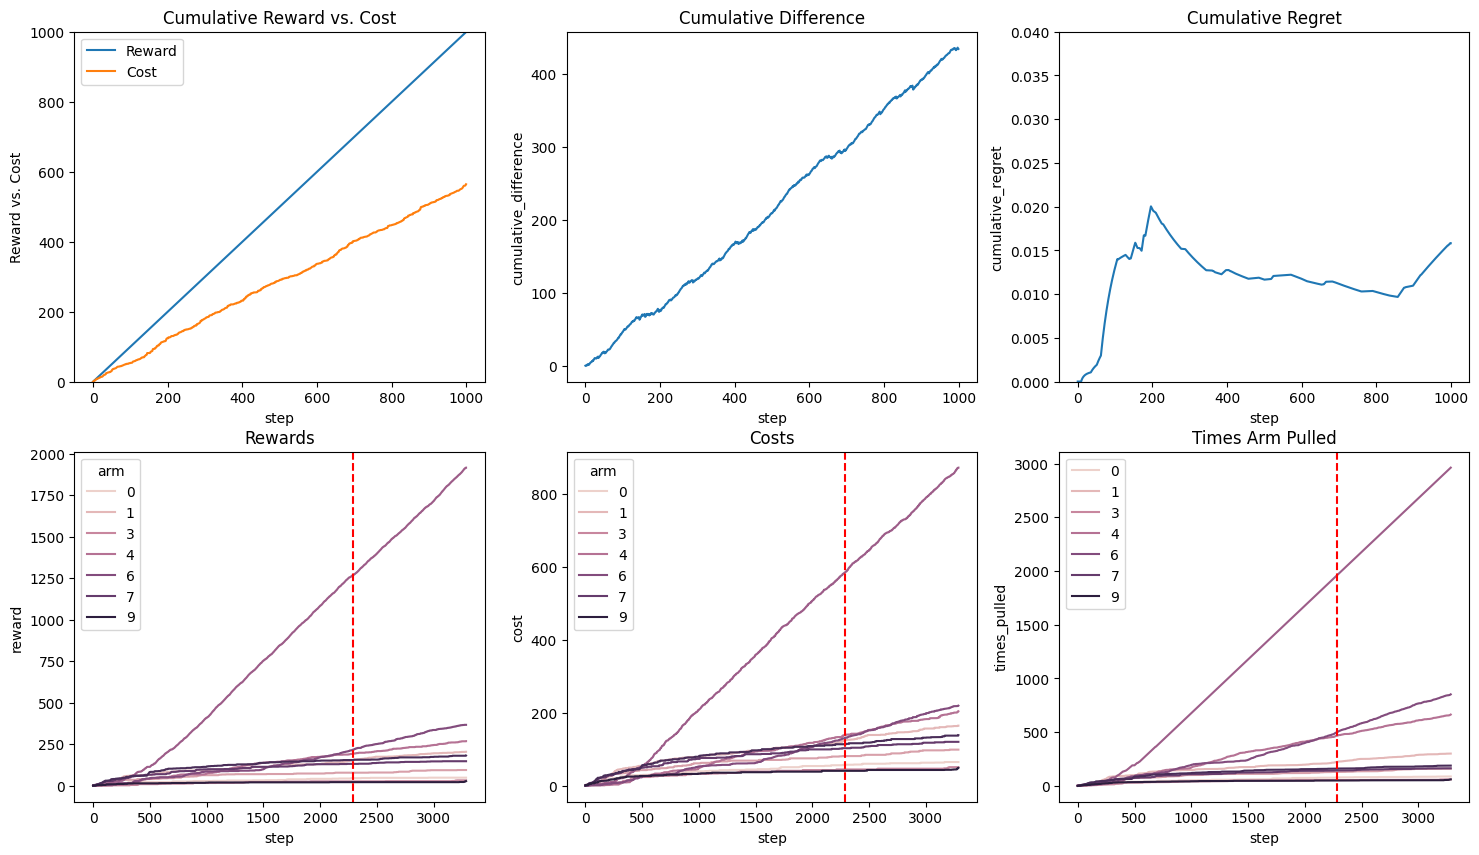

In [9]:
# initialize arms
for arm in range(env_ccb.L):
  env_ccb.pull_arm(arm)
while True:
  ucb_bounds = np.sqrt(alpha_ccb * np.log(step_ccb + 1)/env_ccb.times_pulled)
  upper_arm_bounds = env_ccb.rewards/env_ccb.times_pulled + ucb_bounds
  lower_arm_bounds = np.clip(env_ccb.costs/env_ccb.times_pulled - ucb_bounds, a_min=epsilon_ccb, a_max=None)
  ucb_reward_cost_ratio = upper_arm_bounds / lower_arm_bounds
  ordered_arms = np.argsort(-ucb_reward_cost_ratio)
  step_ordered_arms = ordered_arms[:np.sum(ucb_reward_cost_ratio >= 1)]
  for arm in step_ordered_arms:
    arm_reward, arm_cost = env_ccb.pull_arm(arm)
    if step_ccb > budget_ccb:
      cumulative_reward_ccb += arm_reward
      cumulative_cost_ccb += arm_cost
    if arm_reward == 1:
      break
  step_ccb += 1
  reward_list_ccb.extend(env_ccb.rewards)
  cost_list_ccb.extend(env_ccb.costs)
  times_pulled_list_ccb.extend(env_ccb.times_pulled)

  if step_ccb > budget_ccb:
    cumulative_reward_list_ccb.append(cumulative_reward_ccb)
    cumulative_cost_list_ccb.append(cumulative_cost_ccb)
    cumulative_difference_list_ccb.append(cumulative_reward_ccb - cumulative_cost_ccb)
    env_ccb.update_cumulative_regret(step_ordered_arms)
    cumulative_regret_list_ccb.append(env_ccb.get_cumulative_regret(step_ccb-budget_ccb))
  if step_ccb >= horizon_ccb:
    break

arm_statistics_ccb = pd.DataFrame({"reward": reward_list_ccb, "cost": cost_list_ccb, "times_pulled": times_pulled_list_ccb, "arm": list(range(L_ccb)) * int(len(reward_list_ccb)/L_ccb), "step": sorted(list(range(horizon_ccb)) * L_ccb)})
step_statistics_ccb = pd.DataFrame({"cumulative_regret": cumulative_regret_list_ccb, "cumulative_reward": cumulative_reward_list_ccb, "cumulative_cost": cumulative_cost_list_ccb, "cumulative_difference": cumulative_difference_list_ccb, "step": list(range(horizon_beyond_budget_ccb))})

arm_statistics_ccb_risky = deepcopy(arm_statistics_ccb)
step_statistics_ccb_risky = deepcopy(step_statistics_ccb)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
# Step Statistics
sns.lineplot(data=step_statistics_ccb, x="step", y="cumulative_reward", ax=axes[0][0], label="Reward")
sns.lineplot(data=step_statistics_ccb, x="step", y="cumulative_cost", ax=axes[0][0], label="Cost")
axes[0][0].set_ylabel("Reward vs. Cost")
axes[0][0].set_title("Cumulative Reward vs. Cost")
axes[0][0].set_ylim(0,exploration_horizon)
sns.lineplot(data=step_statistics_ccb, x="step", y="cumulative_difference", ax=axes[0][1])
axes[0][1].set_title("Cumulative Difference")
sns.lineplot(data=step_statistics_ccb, x="step", y="cumulative_regret", ax=axes[0][2])
axes[0][2].set_title("Cumulative Regret")
axes[0][2].set_ylim(0,0.04)
# Arm Statistics
sns.lineplot(data=arm_statistics_ccb, x="step", y="reward", hue="arm", ax=axes[1][0])
axes[1][0].axvline(x=budget_ccb, color='r', linestyle='--')
axes[1][0].set_title("Rewards")
sns.lineplot(data=arm_statistics_ccb, x="step", y="cost", hue="arm", ax=axes[1][1])
axes[1][1].axvline(x=budget_ccb, color='r', linestyle='--')
axes[1][1].set_title("Costs")
sns.lineplot(data=arm_statistics_ccb, x="step", y="times_pulled", hue="arm", ax=axes[1][2])
axes[1][2].axvline(x=budget_ccb, color='r', linestyle='--')
axes[1][2].set_title("Times Arm Pulled")
plt.legend()
plt.show()

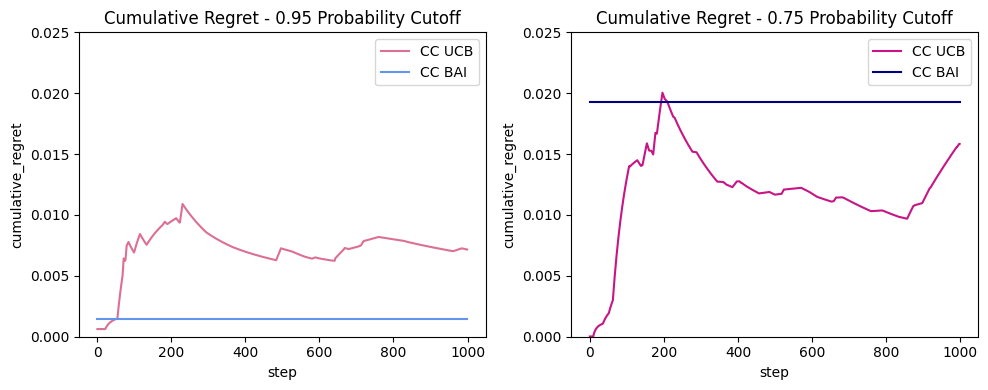

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.lineplot(data=step_statistics_ccb_risk_averse, x="step", y="cumulative_regret", ax=axes[0], color='palevioletred', label='CC UCB')
sns.lineplot(data=step_statistics_ccb_risky, x="step", y="cumulative_regret", ax=axes[1], color='mediumvioletred', label='CC UCB')
sns.lineplot(data=bai_risk_averse.step_statistics, x="step", y="cumulative_regret", ax=axes[0], color='cornflowerblue', label='CC BAI')
sns.lineplot(data=bai_risky.step_statistics, x="step", y="cumulative_regret", ax=axes[1], color='navy', label='CC BAI')
axes[0].set_ylim(0, 0.025)
axes[0].set_title(f"Cumulative Regret - {risk_averse_cutoff} Probability Cutoff")
axes[1].set_ylim(0, 0.025)
axes[1].set_title(f"Cumulative Regret - {risky_cutoff} Probability Cutoff")
plt.legend()
plt.tight_layout()
plt.show()